# Import Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
from imblearn.combine import SMOTETomek

# Load Clean Data & Resample

In [3]:
df = pd.read_csv('secom_clean.csv')
X = df.drop('target', axis=1)
y = df['target']

# Addressing the 14:1 imbalance using SMOTE-Tomek
print("Resampling data to balance classes...")
smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)

Resampling data to balance classes...


# Hyperparameter Tuning (Random Forest)

In [4]:
# Transitioning to non-linear ensembles to capture complex sensor interactions
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

print("Running GridSearchCV for Random Forest optimization (Target: Recall)...")
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print(f"Best Parameters Found: {grid_search.best_params_}")

Running GridSearchCV for Random Forest optimization (Target: Recall)...
Best Parameters Found: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


# Threshold Optimization

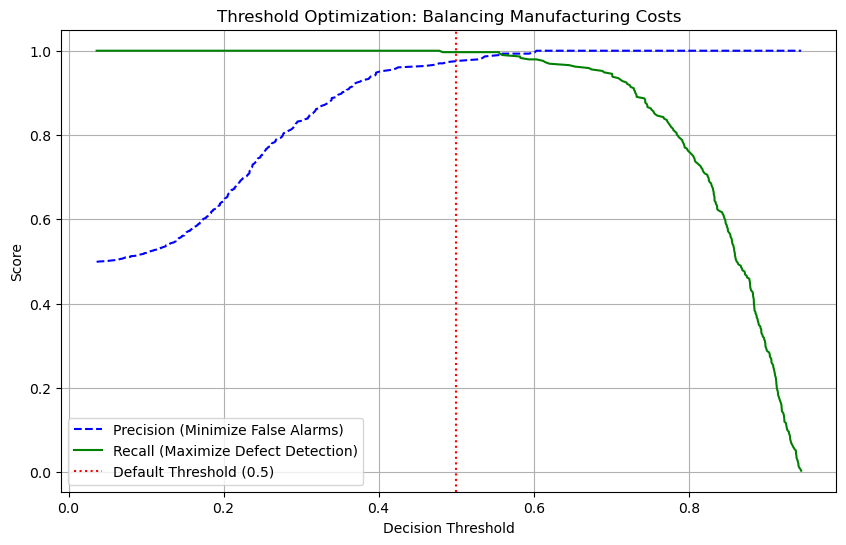

In [6]:
# Getting probability scores for the "Fail" class
y_scores = best_rf.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Visualizing the trade-off
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision (Minimize False Alarms)")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall (Maximize Defect Detection)")
plt.axvline(x=0.5, color='red', linestyle=':', label='Default Threshold (0.5)')
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Threshold Optimization: Balancing Manufacturing Costs")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Selecting a threshold that ensures at least 80% Recall
# In semiconductors, missing a fail is more expensive than a false alarm.
idx = np.where(recalls >= 0.80)[0][-1]
opt_threshold = thresholds[idx]
print(f"Optimized Decision Threshold: {opt_threshold:.4f}")

# Final predictions using the tuned threshold
y_pred_tuned = (y_scores >= opt_threshold).astype(int)

Optimized Decision Threshold: 0.7844


# Model Classification Report

In [16]:
print("\n--- TUNED MODEL CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred_tuned, zero_division=0))


--- TUNED MODEL CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       293
           0       0.00      0.00      0.00         0
           1       1.00      0.80      0.89       292

    accuracy                           0.40       585
   macro avg       0.33      0.27      0.30       585
weighted avg       0.50      0.40      0.44       585



# Business Impact (NOT REAL data)

In [12]:
# ROI Simulation: Simple Industry Logic
# Assuming: $500 saved per caught defect, $100 lost per false alarm
cm = confusion_matrix(y_test, y_pred_tuned)
tp, fp = cm[1, 1], cm[0, 1]
estimated_savings = (tp * 500) - (fp * 100)

print(f"Estimated Operational Savings from this Test Batch: ${estimated_savings:,}")

Estimated Operational Savings from this Test Batch: $-29,300


# Export model as pkl for deployment

In [13]:
# Serializing the model for use in a Manufacturing Execution System (MES)
joblib.dump(best_rf, 'semiconductor_rf_model.pkl')
print("\nModel saved as 'semiconductor_rf_model.pkl' for real-time integration.")


Model saved as 'semiconductor_rf_model.pkl' for real-time integration.
